In [1]:
!nvidia-smi

Fri Apr 25 23:37:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.144                Driver Version: 570.144        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              5W /   80W |     322MiB /   6141MiB |     42%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q transformers sentencepiece gdown inference-gpu supervision more_itertools scikit-learn umap-learn
!pip install -q git+https://github.com/roboflow/sports.git

In [3]:
from inference import get_model
import os
import supervision as sv
from tqdm import tqdm
import torch
from transformers import AutoProcessor, SiglipVisionModel
from more_itertools import chunked
import numpy as np
import umap
from sklearn.cluster import KMeans

[04/25/25 23:37:22] WARNING  Your inference package version 0.47.0 is out of date! Please upgrade to ]8;id=515859;file:///home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=848509;file:///home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.48.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

/home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/inference/models/utils.py:340: ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
  warnings.warn(
/home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/inference/models/utils.py:352: ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
  warnings.warn(
/home/dragos/coursesDeusto/DeepLearning/project2/.venv/lib/python3.12/site-packages/inference/models/utils.py:362: ModelDependencyMis

In [8]:
api_key = os.getenv("ROBOFLOW_TOKEN")
model_id = os.getenv("PLAYER_DETECTION_MODEL_ID")
model = get_model(model_id=model_id, api_key=api_key)

2025-04-25 23:38:17.403802877 [E:onnxruntime:Default, provider_bridge_ort.cc:2036 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1695 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libnvrtc.so.12: cannot open shared object file: No such file or directory

2025-04-25 23:38:17.403818165 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:994 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.


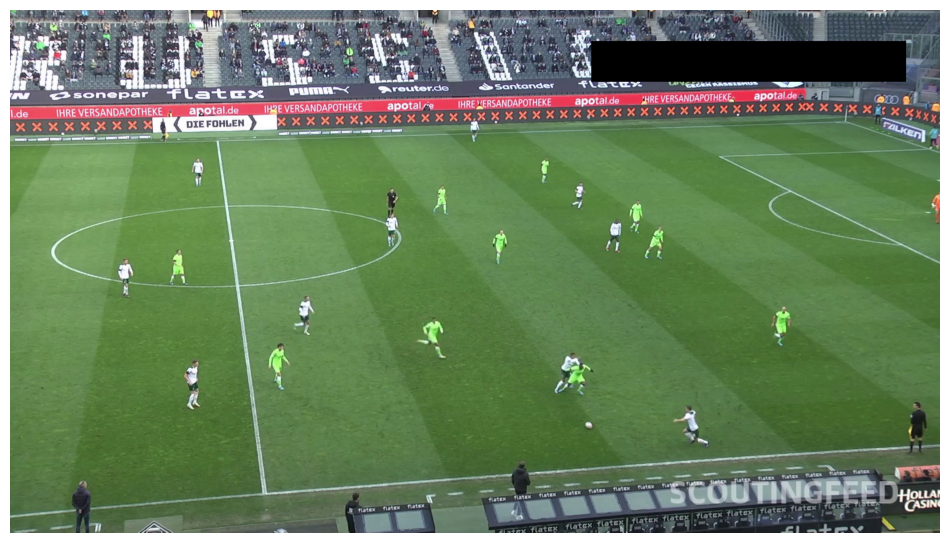

In [9]:
video_info = sv.VideoInfo.from_video_path('08fd33_4.mp4')

frame_generator = sv.get_video_frames_generator(source_path='08fd33_4.mp4')

frame = next(frame_generator)

sv.plot_image(frame)


In [10]:
STRIDE = 30
PLAYER_ID = 2

def extract_crops(video_path):
	frame_generator = sv.get_video_frames_generator(source_path=video_path, stride=STRIDE)

	crops = []
	for frame in tqdm(frame_generator, desc='collecting crops'):
		result = model.infer(frame, confidence=0.3)[0]
		detections = sv.Detections.from_inference(result)
		detections = detections.with_nms(threshold=0.5, class_agnostic=True) # remove overlapping detections
		detecctions = detections[detections.class_id == PLAYER_ID]
		
		crops += [sv.crop_image(frame, xyxy) for xyxy in detecctions.xyxy]
	
	return crops

In [11]:
crops = extract_crops('08fd33_4.mp4')
len(crops)

collecting crops: 25it [01:12,  2.89s/it]


499

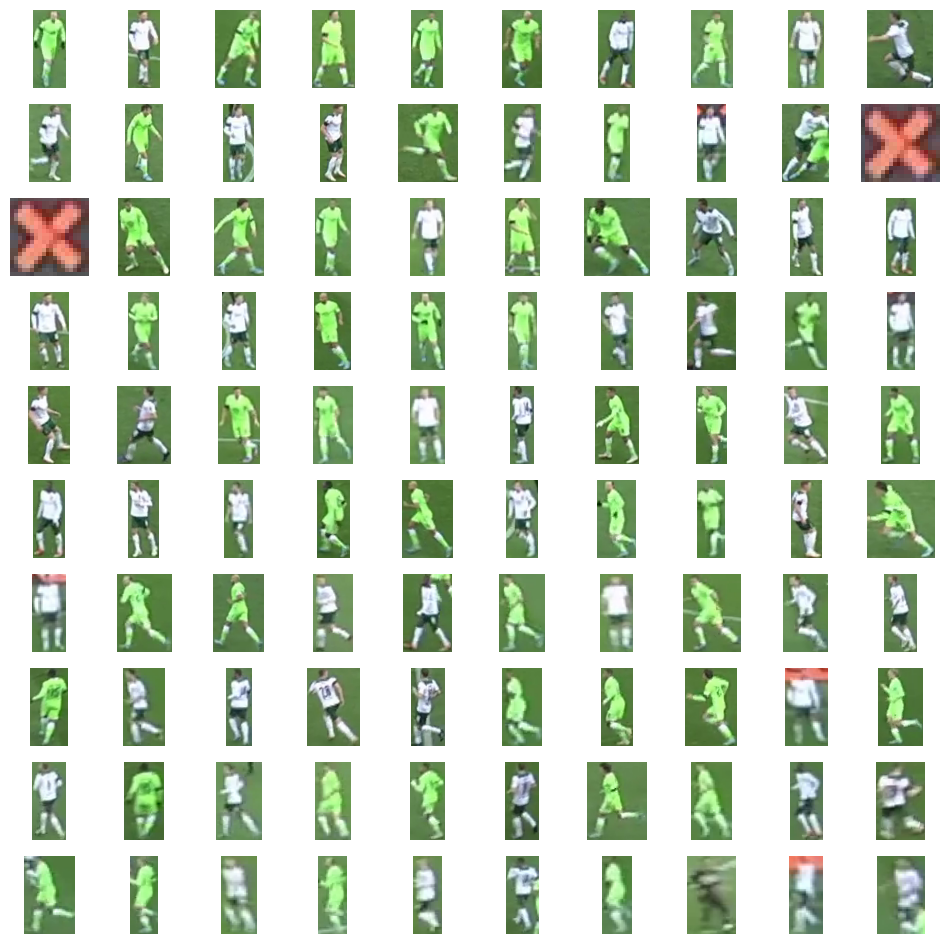

In [12]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

## SigLIP to calc embeddings for each of the crops

### SigLIP expects pillow images

In [13]:
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

Because if you want one embedding for the whole image,
you need to collapse the patches into one single vector.

Each patch describes a small part of the image (e.g., a piece of the field, a player's leg).

In [14]:
BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []

with torch.no_grad():
	for batch in tqdm(batches, desc='embeddings extraction'):
		inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
		outputs = EMBEDDINGS_MODEL(**inputs)
		embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
		data.append(embeddings)

data = np.concatenate(data)

embeddings extraction: 16it [00:49,  3.10s/it]


In [15]:
REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2, random_state=42)

In [16]:
projections = REDUCER.fit_transform(data)

In [17]:
projections.shape

(499, 3)

In [18]:
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [19]:
clusters[:10]

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

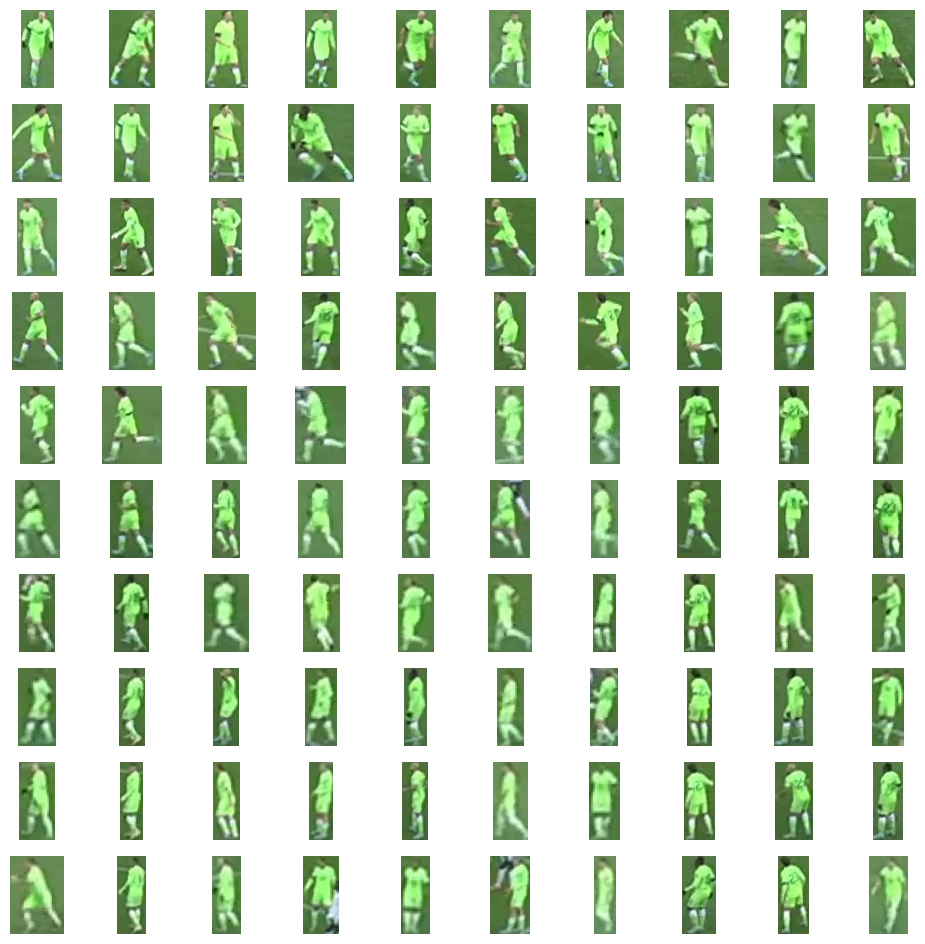

In [20]:
team_0 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]

sv.plot_images_grid(team_0[:100], grid_size=(10, 10))